## The Brownian Bridge

For options with path dependent payoffs, or options whose underlying asset is subject to stochastic volatility it can be helpful to use a Brownian bridge (see the [Wikipedia article](https://en.wikipedia.org/wiki/Brownian_bridge) for more information). For example, if you want to use stratified sampling at the terminal step (i.e. at expiration) for a path dependent option you need to somehow know where the path will end up once it gets to expiration. 

It turns out that the Wiener process enjoys some peculiar properties which allow us to generate the sample paths in a different way. Consider a time interval with left and right end points $t_{l}$ and $t_{r}$ respectively, and an intermediate time instant $s$, such that $t_l < s < t_r$. In standard path generation, we would generate the Wiender process in the natural order: $W(t_l)$, $W(s)$, and finally $W(t_r)$. Using the so-called Brownian bridge, we can generate $W(s)$ conditional on the values $w_l = W(t_l)$ and $w_r = W(t_r)$. It can be shown that $W(s)$, conditional on those two values, is a normal variate with expected value

$$
\frac{(t_r - s) w_l + (s - t_l) w_r}{t_r - t_l}
$$

and variance

$$
\frac{(t_r - s)(s - t_l)}{t_r - t_l}
$$

Using the Brownian bridge, we may generate sample paths by a sort of bisection strategy. Give $W(0) = 0$, we sample $W(T)$; then we sample $W(T/2)$. Given $W(0)$ and $W(T/2)$ we sample $W(T/4)$; given $W(T/2)$ and $W(T)$ we sample $W(3T/4)$, etc. We can actually generate the path in any order we wish, with non-homogenous time steps. This could be useful because it will allow us to use stratified sampling at the terminal time step (and perhaps other intermediate time steps, but we won't worry about that).

A simple `Python` function to generate a Wiener path using the Brownian bridge is given below. You can simply use it as a drop-in replacement for `z = np.random.normal(size=num_steps)` in your simulations and get a bridged path. Try hard to understand it though so that you don't end up using it as a black-box.

___N.B.:___ one thing to keep in mind is that with this bisection strategy the number of time steps in a given path must be a power of two. 

In [61]:
import numpy as np
from math import log2

def WienerBridge(expiry, num_steps, endval = 0.0):
    num_bisect = int(log2(num_steps))
    tjump = int(expiry)
    ijump = int(num_steps - 1)

    if endval == 0.0:
        endval = np.random.normal(scale = np.sqrt(expiry), size=1)

    z = np.random.normal(size=num_steps + 1)
    w = np.zeros(num_steps + 1)
    w[num_steps] = endval
    

    for k in range(num_bisect):
        left = 0
        i = ijump // 2 + 1    ## make sure this is integer division!
        right = ijump + 1
        limit = 2 ** k

        for j in range(limit):
            a = 0.5 * (w[left] + w[right])
            b = 0.5 * np.sqrt(tjump)
            w[i] = a + b * z[i]
            right += ijump + 1
            left += ijump + 1
            i += ijump + 1
        
        ijump //= 2    ## Again, make this is integer division!
        tjump /= 2

    return np.diff(w)  ## Recall the the Brownian motion is the first difference of the Wiener process

## main
num_steps = 2 ** 8
endval = np.random.normal(loc = 0.0, scale = np.sqrt(expiry), size=1)
path = WienerBridge(expiry, num_steps, endval)

In [63]:
endval

array([-0.02189019])

In [4]:
import matplotlib
import matplotlib.pyplot as plt

We can see what this looks like with a simple plot.

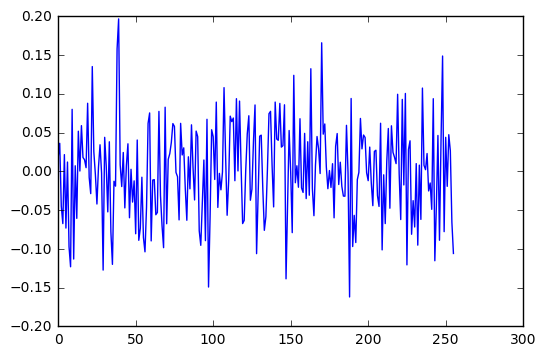

In [64]:
plt.plot(path)
plt.show()

We can now use this function to get a single path and do Monte Carlo as before. Here we will do it in the Black-Scholes world for a single path.

In [67]:
## The same old option (of course!)
spot = 41.0
strike = 40.0
rate = 0.08
vol = 0.30
expiry = 1.0
div = 0.0

num_steps = 2 ** 8
num_reps = 10000
dt = expiry / num_steps

price = np.zeros(num_steps)
price[0] = spot

## NB: this endpoint value could be stratified!
endval = np.random.normal(loc=0.0, scale=np.sqrt(expiry), size=1)

drift = (rate - div - 0.5 * vol * vol) * dt
z = WienerBridge(expiry, num_steps, endval)

for j in range(1,(num_steps)):
    price[j] = price[j-1] * np.exp(drift + vol * z[j])

We can also take a look at the price path that obtains from this bridged Brownian path. 

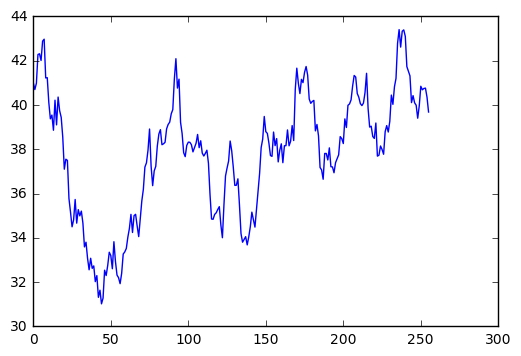

In [68]:
plt.plot(price)
plt.show()

This code is not very optimal. If we adapt it naively it will result in very inefficient Monte Carlo simulation. Let's see if we can come up with a strategy to improve it using vectorization.

In [212]:
def WienerBridge(expiry, num_reps, num_steps, endval):
    num_bisect = int(log2(num_steps))
    tjump = int(expiry)
    ijump = int(num_steps - 1)

    z = np.random.normal(size=(num_reps, num_steps+1))
    w = np.zeros((num_reps, num_steps + 1))
    w[:,num_steps] = endval
    

    for k in range(num_bisect):
        left = 0
        i = ijump // 2 + 1    ## make sure this is integer division!
        right = ijump + 1
        limit = 2 ** k

        for j in range(limit):
            a = 0.5 * (w[:,left] + w[:,right])
            b = 0.5 * np.sqrt(tjump)
            w[:,i] = a + b * z[:,i]
            right += ijump + 1
            left += ijump + 1
            i += ijump + 1
        
        ijump //= 2    ## Again, make this is integer division!
        tjump /= 2

    return np.diff(w)

We now have a version of `WienerBridge` that advances a whole vector along each time step rather than a single path (i.e. we evolve many paths simultaneously at each time step). And it wasn't that difficult. Look it over and make sure you can detect the differences.

Let's first look at the result for a simple case with:

- `num_reps = 10`
- `num_steps = 8` 

In [83]:
num_reps = 10
endval = np.random.normal(size=num_reps)
w = WienerBridge(1.0, 10, 8, endval)

In [81]:
w

array([[-0.60184726, -0.22108832,  0.02239933, -0.18829942,  0.19232745,
        -0.50055607,  0.61140842, -0.04285977],
       [-0.07332117,  0.29572814, -0.16773172, -0.23257044,  0.28648422,
        -0.1380317 ,  0.47036133, -0.13667974],
       [ 0.27770496, -0.13023996, -0.23144858,  0.66087251, -0.13346257,
         0.20205258, -0.12045637, -0.42417849],
       [-0.19633913, -0.52947992, -0.22562638, -0.11716714,  0.51480271,
         0.17663944,  0.29343449,  0.33029609],
       [-0.05230457, -0.14514847, -0.32424698, -0.17181961,  0.01177602,
         0.27148186, -0.02235141,  0.04674209],
       [-0.26946695, -0.24230806,  0.16221149,  0.33324227, -0.34646287,
        -0.09791498, -0.62541758, -0.49629938],
       [ 0.34680833, -0.36876367,  0.44689593, -0.11786218, -0.29528053,
        -0.49279182,  0.08381723, -0.07060686],
       [ 0.19638755,  0.14940078, -0.45022723, -0.17008132, -0.53586372,
        -0.42823038,  0.29140917, -0.25727264],
       [-0.16189855,  0.03635647

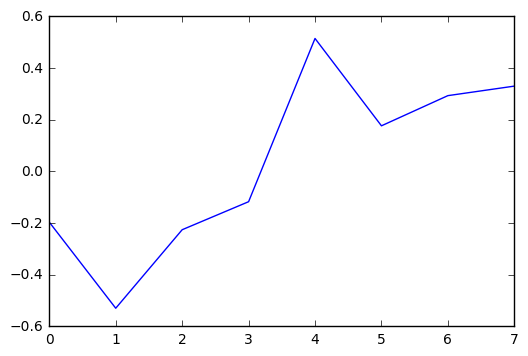

In [82]:
## Let's look at one of the paths
plt.plot(w[3,:])
plt.show()

## Brownian Bridge for Monte Carlo and Stratified Sampling

In [180]:
def StratifiedSample(M = 100):
    u = np.random.uniform(size=M)  
    i = np.arange(M)
    uhat = (u + i) / M

    return uhat

In [220]:
from scipy.stats import norm

def CallPayoff(spot, strike):
    return np.maximum(spot - strike, 0.0)

def StratifiedMonteCarloPricer(spot, strike, rate, vol, div, expiry, num_reps, num_steps):
    uhat = StratifiedSample(num_reps)
    endval = norm.ppf(uhat)
    z = WienerBridge(expiry, reps, steps, endval)
    
    spotT = np.zeros((num_reps, num_steps))
    spotT[:,0] = spot
    
    dt = expiry / num_steps
    drift = (rate - div - 0.5 * vol * vol) * dt
    
    for i in range(1, num_steps):
        spotT[:,i] = spotT[:,i-1] * np.exp(drift + vol * z[:,i])
    

    callT = CallPayoff(spotT[:,-1], strike)
    price = callT.mean() * np.exp(-rate * expiry)
    
    return (spotT, callT, z, uhat)
    #return price

## main
spot = 41.0
strike = 40.0
rate = 0.08
vol = 0.30
expiry = 1.0
div = 0.0
reps = 5
steps = 2 ** 2

(paths, payoffs, z, u) = StratifiedMonteCarloPricer(spot, strike, rate, vol, div, expiry, reps, steps)



#callPrc = StratifiedMonteCarloPricer(spot, strike, rate, vol, div, expiry, reps, steps)
#fmt = "The Call Price estimated via Stratified Monte Carlo is: {0:0.3f}".format(callPrc)
#print(fmt)

In [221]:
paths

array([[ 41.        ,  37.12849283,  31.70842282,  31.17631278],
       [ 41.        ,  49.21940973,  44.30230289,  40.15970598],
       [ 41.        ,  40.77999957,  43.3450607 ,  48.51749469],
       [ 41.        ,  38.16681947,  38.29617169,  40.39936148],
       [ 41.        ,  48.56951861,  48.7051934 ,  57.54375246]])

In [222]:
payoffs

array([  0.        ,   0.15970598,   8.51749469,   0.39936148,  17.54375246])

In [223]:
z

array([[-0.47201399, -0.3597913 , -0.55517442, -0.08557916],
       [-0.60916317,  0.57988662, -0.38000464, -0.35640835],
       [-0.5682128 , -0.04710104,  0.17417001,  0.34660564],
       [ 0.43174008, -0.26785176, -0.01788868,  0.14904682],
       [-0.06479853,  0.53558026, -0.01986827,  0.52669969]])

In [224]:
u

array([ 0.07043501,  0.22193052,  0.46234082,  0.61602081,  0.83586715])

In [225]:
norm.ppf(u)

array([-1.47255887, -0.76568954, -0.09453819,  0.29504646,  0.97761315])

In [217]:
zhat = norm.ppf(u)

In [218]:
w = WienerBridge(1.0, reps, steps, zhat )

In [214]:
reps

5

In [215]:
steps

4

In [219]:
w

array([[-0.30055302, -0.40208048, -0.01345418, -0.75946384],
       [ 0.29467541,  0.42197187, -0.68171251, -0.75690016],
       [ 0.16769272, -0.65263644,  0.74481558, -0.1316429 ],
       [ 0.38344399, -0.06852313,  0.16684467,  0.03195912],
       [ 0.32871815, -0.05287343,  0.38315241,  0.19258818]])